In [1]:
%load_ext autoreload
%autoreload 2

### Static Mnist Video - Heatmap Prediction

Heatmap is predicted in a video with static unmoving frames where an mnist digit is placed randomly in a larger canvas.

An LSTM cell is used to track the internal state of the model while generating a heatmap for every frame.

Training is done by unrolling up to 6 past frames.

#### Issue with BasicLSTMCell

Its implementation does not easily allow feed-forward of heatmap outputs from previous frames.

This means that a "running" evaluation of the network is not possible. It is limited to segments of 6 frames.

To partially circumvent the issue, a previous known dependable heatmap could be passed in along with the first `t-6` frame during training and the timeframe `t=6` be increased.

In [2]:
from generate import *

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
time_steps=6
num_units=128
imsize=64
infsize=16

In [4]:
import tensorflow as tf
sess = tf.Session()

In [5]:
inputs = tf.placeholder(tf.float32, [None, time_steps, imsize, imsize])
labels = tf.placeholder(tf.float32, [None, time_steps, infsize, infsize, 1])

input_steps = tf.unstack(inputs, time_steps, 1)

conv_results = []
for frame in input_steps:
    shaped_frame = tf.reshape(frame, [-1, imsize, imsize, 1])
    
    # conv weights are shared across time steps t-6 .... t
    with tf.variable_scope('SingularConv', reuse=tf.AUTO_REUSE):
        # 64
        carry = tf.layers.conv2d(shaped_frame, 32, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 64, 3, (2, 2), padding='same', activation=tf.nn.relu)

        # 32
        carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 128, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
        # 16
#         carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
#         carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
#         carry = tf.layers.conv2d(carry, 256, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
#         carry = tf.layers.conv2d(carry, 256, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
        conv_results.append(carry)

In [6]:
print(len(conv_results))
print(conv_results[0].shape)
flattened_steps = [tf.reshape(result, [-1, 16**2 * 128]) for result in conv_results]
print(flattened_steps[0].shape)
# assert False

6
(?, 16, 16, 128)
(?, 32768)


In [7]:
from tensorflow.contrib import rnn

#defining the network
lstm_cell=rnn.BasicLSTMCell(512)
lstm_out, _ = rnn.static_rnn(lstm_cell, flattened_steps,dtype=tf.float32)

In [8]:
guess_results = []
guess_losses = []
label_steps = tf.unstack(labels, time_steps, 1)
for ii, state in enumerate(lstm_out):
    
    # shared weights for: t-6 .... t
    with tf.variable_scope('SingularRegr', reuse=tf.AUTO_REUSE):
        carry = tf.layers.dense(state, 16**2 * 128)
        carry = tf.reshape(carry, [-1, 16, 16, 128])
        carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 1, 3, (1, 1), padding='same')
        
        local_result = carry
        guess_results.append(local_result)
        local_loss = tf.nn.l2_loss(local_result - label_steps[ii])
        guess_losses.append(local_loss)


total_loss = tf.reduce_mean(guess_losses)
heat_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)

In [9]:
def random_noise(videos, perc=0.1): # 10% of videos will have noised out frames
    for video in videos:
        flip = np.random.randint(100)
        if flip < int(perc * 100):
            random_frame = np.random.randint(1, 5)
            video[random_frame] = np.random.rand(video[random_frame].shape[1], video[random_frame].shape[0])

In [10]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

MAX_ITER = 800
BATCH_SIZE=16

init=tf.global_variables_initializer()

sess.run(init)

def prep_data(batch_x, batch_y, bsize=BATCH_SIZE):
    batch_x = batch_x.reshape((bsize,28,28))
    animated = [animate(place(digit, frame_size=64), steps=5, size=64) for digit in batch_x]

    videos = np.array([data[0] for data in animated])
    all_coords = [data[1] for data in animated]
    
    heat_videos = np.array([matching_heatmap(series, framesize=64) for series in all_coords])
#     print(heat_videos.shape)
#     assert False
    heat_videos = heat_videos.reshape((bsize, time_steps, 16, 16, 1))

    return videos, heat_videos
    
epoch = 1
while epoch < MAX_ITER:
    batch_x, batch_y = mnist.train.next_batch(batch_size=BATCH_SIZE)

    static_video, sized_heats = prep_data(batch_x, batch_y)
    random_noise(static_video, perc=0.1)

    sess.run(heat_opt, feed_dict={inputs: static_video, labels:sized_heats })

    if epoch %10==0:
        train_loss = sess.run(total_loss,feed_dict={inputs:static_video,labels:sized_heats})
        
        
        test_data = mnist.test.images[:128].reshape((-1, 28, 28))
        test_label = mnist.test.labels[:128]
        static_video, sized_heats = prep_data(test_data, test_label, bsize=128)
        test_loss = sess.run(total_loss, feed_dict={inputs: static_video, labels: sized_heats})


        sys.stdout.write('[%d/%d] L = %.2f / %.2f\r' % (epoch, MAX_ITER, train_loss / BATCH_SIZE, test_loss / 128))
        sys.stdout.flush()

    epoch = epoch + 1
    
print()

# # calculating test accuracy


[790/800] L = 0.01 / 0.01


In [11]:
test_data = mnist.test.images[:1].reshape((-1, 28, 28))
test_label = mnist.test.labels[:1]
static_video, sized_heats = prep_data(test_data, test_label, bsize=1)

random_noise(static_video, perc=1.0)

heat_guesses = sess.run(guess_results, feed_dict={inputs: static_video, labels: sized_heats})
print(len(heat_guesses), heat_guesses[0].shape)

6 (1, 16, 16, 1)


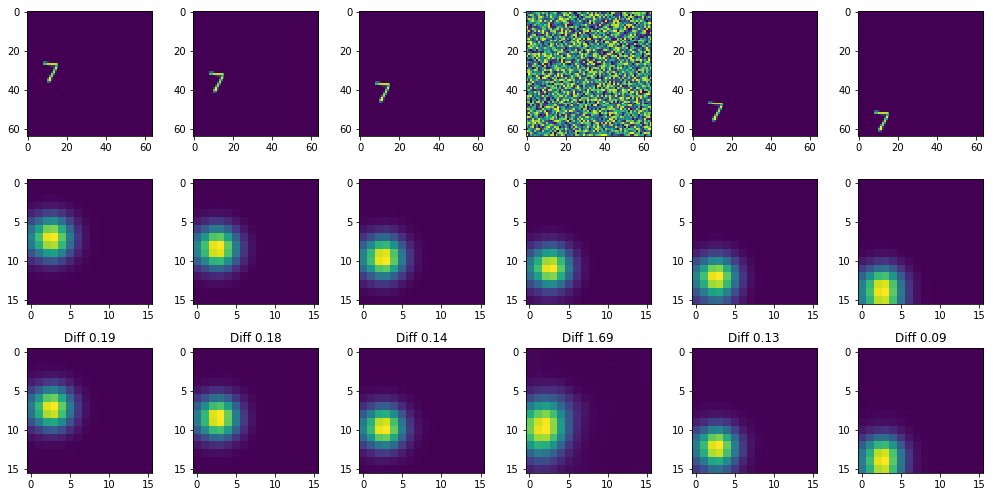

In [12]:
import numpy.linalg as la

plt.figure(figsize=(14, 7))
for ii in range(6):
    plt.subplot(3, 6, ii+1)
    plt.imshow(static_video[0][ii])
    
for ii in range(6):
    plt.subplot(3, 6, ii+6+1)
    plt.imshow(np.squeeze(sized_heats[0][ii]))
    
for ii in range(6):
    plt.subplot(3, 6, ii+6+6+1)
    plt.gca().set_title('Diff %.2f' % la.norm(np.squeeze(heat_guesses[ii]) - np.squeeze(sized_heats[0][ii])))
    plt.imshow(np.squeeze(heat_guesses[ii]))

plt.tight_layout()
plt.show()
